#### In this notebook is performed the aplication of the Canny algorithm to MUR data.

So, first of all, the various functions required to import the MUR data in the form of netCDF files are defined.
The files are imported and converted to dataframes. Then we will apply the Canny algorithm to these data and test things such as applying a mask to the continental area, apply gaussian filter to the data

In [1]:
#Import libraries

import os
import wget
import threading
import numpy as np
import pandas as pd
from math import floor
from pydap.client import open_url
from tqdm import tqdm
import sys
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import cv2
import matplotlib
from matplotlib.colors import ListedColormap


plt.rcParams["figure.figsize"] = 12, 8

### Code to download data from MUR

The following functions and code allow to download data from MUR, which will be saved as netCDF files in the data directory

In [2]:
def boundingindex(dmin, dint, boundary0, boundary1):
    """
    get boundaries values to download the data already cropped
    """
    inx0 = max(int(floor((boundary0 - dmin) / dint)), 0)
    inx1 = max(int(floor((boundary1 - dmin) / dint)), 0)
    if inx0 > inx1:
        atemp = inx0
        inx0 = inx1
        inx1 = atemp
    return [inx0, inx1]

In [3]:
def get_mur_params(lon_box, lat_box):
    """
    Check sample file to get parameters for sst
    """
    mur_ncin = open_url(
        'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2018/002/20180102090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc')
    lon = mur_ncin['lon']
    lat = mur_ncin['lat']
    lon_step = np.mean(np.diff(lon))
    lat_step = np.mean(np.diff(lat))
    [mur_i0, mur_i1] = boundingindex(lon[0][0].data, lon_step, lon_box[0], lon_box[1])
    [mur_j0, mur_j1] = boundingindex(lat[0][0].data, lat_step, lat_box[0], lat_box[1])

    return mur_i0, mur_i1, mur_j0, mur_j1

In [5]:
get_mur_params([-19, -5], [35, 45])

(16099, 17499, 12499, 13499)

In [4]:
def download_from_url(fileget, filenameout, replace, printiti):
    """
    function that tries to download data from "fileget" if the data didn't previously exist,
    the user asked to replace the old data, or the file has 0 bytes
    """
    exists = os.path.exists(filenameout)
    if exists:
        file_size = os.path.getsize(filenameout)
    else:
        file_size = 1
    if (not exists) or (replace and exists) or (file_size == 0):
        if exists:
            os.remove(filenameout)
        try:
            return wget.download(fileget, out=filenameout, bar=None)
        except Exception as e:
            if printiti:
                print(e)
                print("Error downloading")
                print("Download error url: " + fileget)
            return e
    return filenameout

In [5]:
def download_sst(path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    opendap_dir = 'https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/' + str(
        date.year) + '/'
    filename = opendap_dir + "{0:0>3}".format(str(date.dayofyear)) + '/' + date.strftime(
        "%Y%m%d") + '090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.nc4'
    filenameout = path + "sst_" + date.strftime("%Y%m%d") + '.nc'
    fileget = filename + '?analysed_sst[0:1:0][' + str(mur_j0) + ':1:' + str(mur_j1) + '][' + str(mur_i0) + ':1:' + str(
        mur_i1) + ']'
    download_from_url(fileget, filenameout, replace, 1)
    return

In [6]:
def download_sst_thread(data_range, sst_path, mur_j0, mur_j1, mur_i0, mur_i1, replace):
    for date in tqdm(data_range, desc='SST', file=sys.stdout):
        download_sst(sst_path, date, mur_j0, mur_j1, mur_i0, mur_i1, replace)
    return

In [38]:
#Import several days simultaneously
download_sst_thread(data_range = pd.date_range(start=pd.to_datetime('20190901'), end=pd.to_datetime('20190930')), sst_path='../data/', mur_j0=12499, mur_j1=13499, mur_i0=16099, mur_i1=17499, replace=None)

SST: 100%|██████████████████████████████████████| 30/30 [01:53<00:00,  3.79s/it]


In [7]:
# Download individual days of MUR data
download_sst(path = "../data/", date = pd.to_datetime('20220615'), mur_j0=12499, mur_j1=13499, mur_i0=16099, mur_i1=17499, replace=None)

#### Merge the netCDF files with MUR data

In [39]:
ds = xr.open_mfdataset('../data/sst*.nc',combine = 'nested', concat_dim="time")

In [40]:
ds.to_netcdf('../data/murSept2019.nc')

### Import MUR data

Import the netCDF file from the repository's data folder and then convert it to dataframe format

In [8]:
current_path = os.getcwd()
current_path

'/home/luisfigueiredo/JUNO/notebooks'

In [9]:
from pathlib import Path

data_folder = os.path.join(current_path,"../data")
data_folder

'/home/luisfigueiredo/JUNO/notebooks/../data'

In [10]:
nc_path = os.path.join(data_folder, "sst_20220615.nc")
ds = nc.Dataset(nc_path)
data = xr.load_dataset(nc_path)

In [11]:
print(ds) 

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: CF-1.7
    title: Daily MUR SST, Interim near-real-time (nrt) product
    summary: A merged, multi-sensor L4 Foundation SST analysis product from JPL.
    references: http://podaac.jpl.nasa.gov/Multi-scale_Ultra-high_Resolution_MUR-SST
    institution: Jet Propulsion Laboratory
    history: near real time (nrt) version created at nominal 1-day latency.
2022-06-29 07:11:26 GMT Hyrax-1.16.0 https://podaac-opendap.jpl.nasa.gov/opendap/allData/ghrsst/data/GDS2/L4/GLOB/JPL/MUR/v4.1/2022/177/20220626090000-JPL-L4_GHRSST-SSTfnd-MUR-GLOB-v02.0-fv04.1.nc.nc4?analysed_sst[0:1:0][12499:1:13499][16099:1:17499]
    comment: Interim-MUR(nrt) will be replaced by MUR-Final in about 3 days; MUR = \"Multi-scale Ultra-high Resolution\"
    license: These data are available free of charge under data policy of JPL PO.DAAC.
    id: MUR-JPL-L4-GLOB-v04.1
    naming_authority: org.ghrsst
    product_

In [12]:
#Convert the netCDF file to a dataframe
datadf = data.to_dataframe()
datadf = datadf.reset_index()

In [13]:
datadf['analysed_sst'] =  datadf['analysed_sst']-273.15    #convert to celsius
datadf

,lat,lon,time,analysed_sst
0,35.0,-19.000000,2022-06-26 09:00:00,19.932007
1,35.0,-18.990000,2022-06-26 09:00:00,19.923004
2,35.0,-18.980000,2022-06-26 09:00:00,19.912994
3,35.0,-18.969999,2022-06-26 09:00:00,19.902008
4,35.0,-18.959999,2022-06-26 09:00:00,19.890991
...,...,...,...,...
1402396,45.0,-5.040000,2022-06-26 09:00:00,18.226990
1402397,45.0,-5.030000,2022-06-26 09:00:00,18.235992
1402398,45.0,-5.020000,2022-06-26 09:00:00,18.251007
1402399,45.0,-5.010000,2022-06-26 09:00:00,18.273010


In [14]:
#Dataframe with MUR data for the 15th of June 2022
june15_2022_mur = datadf[datadf['time'] == '2022-06-26 09:00:00']
june15_2022_mur

,lat,lon,time,analysed_sst
0,35.0,-19.000000,2022-06-26 09:00:00,19.932007
1,35.0,-18.990000,2022-06-26 09:00:00,19.923004
2,35.0,-18.980000,2022-06-26 09:00:00,19.912994
3,35.0,-18.969999,2022-06-26 09:00:00,19.902008
4,35.0,-18.959999,2022-06-26 09:00:00,19.890991
...,...,...,...,...
1402396,45.0,-5.040000,2022-06-26 09:00:00,18.226990
1402397,45.0,-5.030000,2022-06-26 09:00:00,18.235992
1402398,45.0,-5.020000,2022-06-26 09:00:00,18.251007
1402399,45.0,-5.010000,2022-06-26 09:00:00,18.273010


### Map accordingly to the netCDF data of MUR (True Temperature values)

In [31]:
# Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
sst = june15_2022_mur.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values

In [32]:
sst = np.flipud(sst)   #flipud -> Reverse the order of elements along axis 0 (up/down).

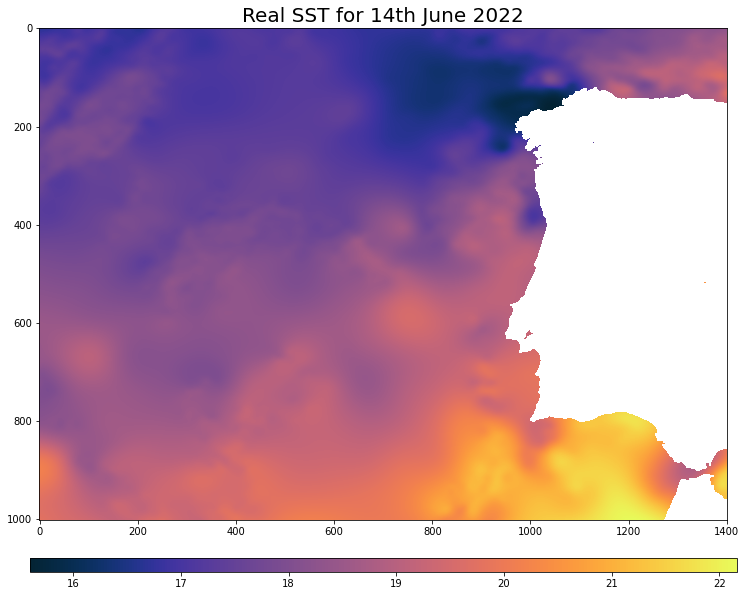

In [33]:
#Plot the array 
plt.rcParams["figure.figsize"] = 14, 10
import cmocean
img = plt.imshow(sst, cmocean.cm.thermal)
plt.colorbar(img, orientation='horizontal', fraction=0.026, pad=0.07, aspect=50)
plt.title('Real SST for 14th June 2022', fontsize=20);


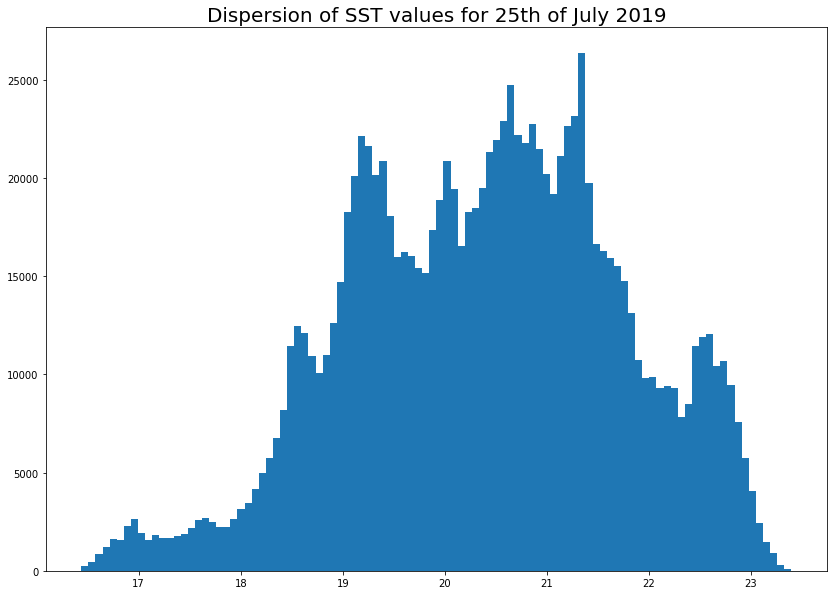

In [59]:
plt.hist(sst.flatten(), bins=100)
plt.title('Dispersion of SST values for 25th of July 2019', fontsize=20);

# Canny Algorithm

#### Apply Canny to the MUR data with the Temperature values in a range 0-255, without mask

In order to apply the Canny algorithm, the values will be in the range of 0-255 and must be in format uint8

In [34]:
# Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
sst2 = june15_2022_mur.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values
    
#Convert Temperature values to uint8 format with values in the range of 0-255
sst3 = ((sst2 - np.nanmin(sst2)) * (1/(np.nanmax(sst2) - np.nanmin(sst2)) * 255)).astype('uint8')

sst3 = np.flipud(sst3)   #flipud -> Reverse the order of elements along axis 0 (up/down).

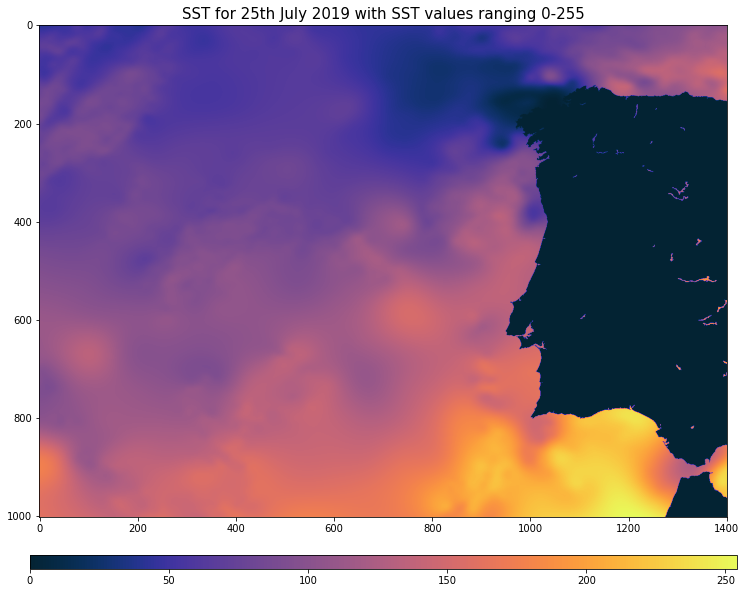

In [35]:
img2 = plt.imshow(sst3, cmocean.cm.thermal)
plt.rcParams["figure.figsize"] = 14, 10
plt.colorbar(img2, orientation='horizontal', fraction=0.026, pad=0.07, aspect=50)
plt.title('SST for 25th July 2019 with SST values ranging 0-255', fontsize=15);

In [18]:
#apply the openCV canny() function to our data
canny = cv2.Canny(sst3, 90, 180, L2gradient=True, apertureSize=3)

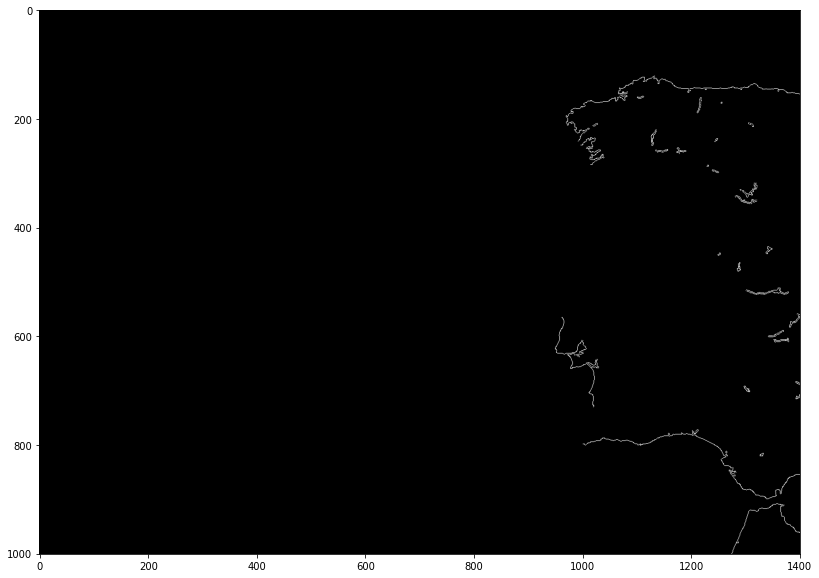

In [19]:
#Visualize the results from the application of the Canny Algorithm
plt.imshow(canny, 'gray')

#### Apply Canny algorithm to MUR data with temperature values in range 0-255, with Mask

In [36]:

# Convert the df to a numpy array with the SST values for the coordinate pair (longitude and latitude)
sst4 = june15_2022_mur.pivot_table(index='lon', columns='lat', values='analysed_sst').T.values
    
#Convert Temperature values to uint8 format with values in the range of 0-255
sst5 = ((sst4 - np.nanmin(sst4)) * (1/(np.nanmax(sst4) - np.nanmin(sst4)) * 255)).astype('uint8')

sst5 = np.flipud(sst5)   #flipud -> Reverse the order of elements along axis 0 (up/down).
    
#apply the canny algorithm and plot the image with the edges
canny_mask = cv2.Canny(sst5, 220, 250, L2gradient=False, apertureSize=5)
    
mask = np.isnan(np.flipud(sst4))    #Boolean array: True where array Temp had Null Values (correspond to the continental zone)
mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")   #array which values= 255 when mask=True
#Dilation to ensure that the pixels that belong to the "shore/continental zone" are not considered fronts 
kernel = np.ones((3,3), np.uint8)
mask_dilated = cv2.dilate(mask255, kernel)
canny_mask =np.ma.masked_where(mask_dilated==255, canny_mask)   #Mask an array where a condition is met.

Text(0.5, 1.0, 'Canny Algorithm for 15th June 2022 (MUR)')

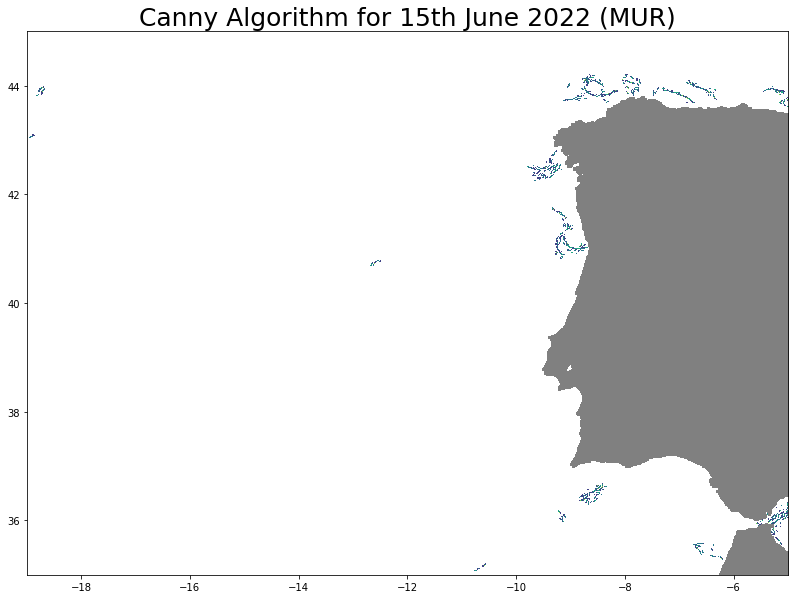

In [40]:
viridis = matplotlib.cm.get_cmap('viridis', 6)
newcolor = viridis(np.linspace(0,1,6))
white = np.array([1, 1, 1, 1])
newcolor[0, :] = white
newcmp = ListedColormap(newcolor)
newcmp.set_bad(color='gray')

plt.imshow(canny_mask, cmap=newcmp, extent=[lon[0], lon[-1], lat[0], lat[-1]])
plt.title("Canny Algorithm for 15th June 2022 (MUR)", fontsize=25)

### Apply Canny algorithm to MUR data with temperature values in range 0-255, with Mask and Gaussian filter


In [42]:
from scipy.ndimage import gaussian_filter

In [43]:
sst_gaussfilter = sst5.copy()
sst_gaussfilter

array([[ 40,  40,  41, ..., 104, 104, 104],
       [ 41,  41,  41, ..., 105, 105, 105],
       [ 41,  41,  42, ..., 105, 105, 105],
       ...,
       [162, 162, 162, ...,   0,   0,   0],
       [162, 162, 162, ...,   0,   0,   0],
       [163, 162, 162, ...,   0,   0,   0]], dtype=uint8)

In [44]:
sst_gaussfilter = gaussian_filter(sst_gaussfilter, sigma=5)   
sst_gaussfilter

array([[ 42,  42,  42, ..., 105, 105, 105],
       [ 42,  42,  42, ..., 105, 105, 105],
       [ 42,  42,  42, ..., 105, 105, 105],
       ...,
       [160, 160, 160, ...,   0,   0,   0],
       [160, 160, 160, ...,   0,   0,   0],
       [160, 160, 160, ...,   0,   0,   0]], dtype=uint8)

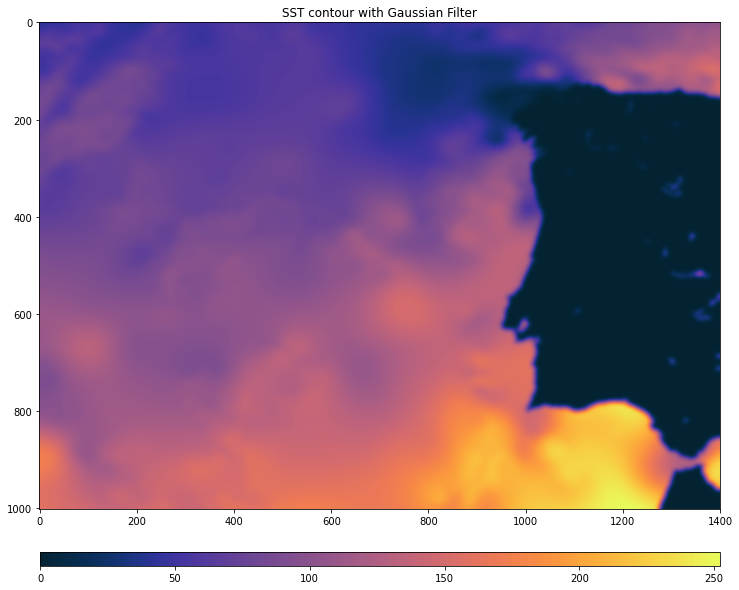

In [45]:
img3 = plt.imshow(sst_gaussfilter, cmocean.cm.thermal)
plt.colorbar(img3, orientation='horizontal', fraction=0.025, pad=0.08, aspect=50)
plt.title('SST contour with Gaussian Filter')
plt.show()

In [46]:
canny_gaussfilter = cv2.Canny(sst_gaussfilter, 120, 240, L2gradient=True, apertureSize=5)

In [38]:
lat = june15_2022_mur['lat'].to_numpy()    #Aug1_mur ->to get the values of latitude and longitude (for MUR data)
lon = june15_2022_mur['lon'].to_numpy()
lat = np.unique(lat).round(3)
lon = np.unique(lon).round(3)

In [47]:
#Apply mask to define continental zone

mask = np.isnan(np.flipud(sst4))    #Boolean array: True where array sst4 had Null Values (correspond to the continental zone)
mask255 =np.where(mask,(np.ones(mask.shape))*255,0).astype("uint8")  #array which values= 255 when mask=True
#Dilation to ensure that the pixels that belong to the "shore/continental zone" are not considered fronts 
kernel = np.ones((3,3), np.uint8)
mask_dilated = cv2.dilate(mask255, kernel)
canny_gaussfilter =np.ma.masked_where(mask_dilated==255, canny_gaussfilter)

Text(0.5, 1.0, 'Canny Algorithm for 15th June 2022 (MUR)')

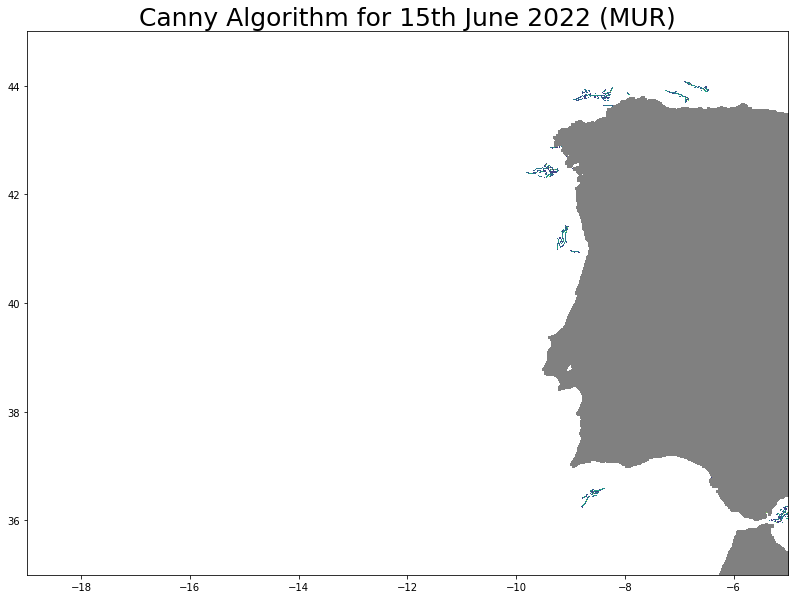

In [48]:
viridis = matplotlib.cm.get_cmap('viridis', 6)
newcolor = viridis(np.linspace(0,1,6))
white = np.array([1, 1, 1, 1])
newcolor[0, :] = white
newcmp = ListedColormap(newcolor)
newcmp.set_bad(color='gray')

plt.imshow(canny_gaussfilter, cmap=newcmp, extent=[lon[0], lon[-1], lat[0], lat[-1]])
plt.title("Canny Algorithm for 15th June 2022 (MUR)", fontsize=25)